In [97]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin
from scipy.stats import pearsonr
from scipy.optimize import root

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#SEED = 35010732 # from random.org
#np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [98]:
def correlated_ts(c,delta_t = 0.1,N=1000):
    # parameters for coupled oscillator
    K,D = 1.0,1.0
    data1 = langevin.time_series(A=1/K, D=D, delta_t=delta_t, N=N)
    data2 = langevin.time_series(A=1/(K+np.abs(c)), D=D, delta_t=delta_t, N=N)
    x1 = (data1 + data2)/2
    if c>0:
        x2 = (data1 - data2)/2
    else:
        x2 = (data2-data1)/2

    return x1,x2

def c_rho(rho):
    return 2*np.abs(rho)/(1-np.abs(rho))*np.sign(rho)


In [99]:
def calc_fundstats(x):
    return x[0]**2+x[-1]**2,np.sum(x[1:-1]**2),np.sum(x[0:-1]*x[1:])

In [100]:
def b(D,A,delta_t):
    return np.exp(-D/A*delta_t)

def q(aep,ass,ac,b):
    return (aep + (1+b**2)*ass - 2*b*ac)/(1-b**2)

def dqdB(aep,ass,ac,b):
    return 2*(b*aep+2*b*ass-(1+b**2)*ac)/(1-b**2)**2

def d2qdB2(aep,ass,ac,b):
    return (6*b+2)/(1-b**2)**3*(aep+2*ass)-(4*b**3+12*b)/(1-b**2)**3*ac

def dBdA(b,D,A,delta_t):
    return b*D*delta_t/A**2

def dBdD(b,A,delta_t):
    return -b*delta_t/A

def d2BdA2(b,D,A,delta_t):
    return b*D*delta_t/A**3*(D*delta_t/A-2)

def d2BdD2(b,A,delta_t):
    return b*delta_t**2/A**2

def d2BdAdD(b,D,A,delta_t):
    return b*delta_t/A**2*(1-D*delta_t/A)

def d2qdD2(aep,ass,ac,b,A,delta_t):
    return d2qdB2(aep,ass,ac,b)*dBdD(b,A,delta_t)**2+dqdB(aep,ass,ac,b)*d2BdD2(b,A,delta_t)

def d2qdA2(aep,ass,ac,b,D,A,delta_t):
    return d2qdB2(aep,ass,ac,b)*dBdA(b,D,A,delta_t)**2+dqdB(aep,ass,ac,b)*d2BdA2(b,D,A,delta_t)

def d2qdAdD(aep,ass,ac,b,D,A,delta_t):
    return d2qdB2(aep,ass,ac,b)*dBdA(b,D,A,delta_t)*dBdD(b,A,delta_t)+dqdB(aep,ass,ac,b)*d2BdAdD(b,D,A,delta_t)

def d2PdA2(N,aep,ass,ac,b,D,A,delta_t):
    return (N/2/A**2 - 
            q(aep,ass,ac,b)/A**3 +
            (N-1)/(1-b**2)*(b*d2BdA2(b,D,A,delta_t) + dBdA(b,D,A,delta_t)**2*(1+b**2)/(1-b**2)) -
            d2qdA2(aep,ass,ac,b,D,A,delta_t)/2/A +
           1/A*dqdB(aep,ass,ac,b)*dBdA(b,D,A,delta_t))
        
def d2PdAdD(N,aep,ass,ac,b,D,A,delta_t):
    return (dqdB(aep,ass,ac,b)*dBdD(b,A,delta_t)/2/A**2 -
            d2qdAdD(aep,ass,ac,b,D,A,delta_t)/2/A +
            (N-1)/(1-b**2)*(b*d2BdAdD(b,D,A,delta_t) + dBdA(b,D,A,delta_t)*dBdD(b,A,delta_t)*(1+b**2)/(1-b**2)))

def d2PdD2(N,a1ep,a1ss,a1c,a2ep,a2ss,a2c,b1,b2,D,A1,A2,delta_t):
    return ((N-1)/(1-b1**2)*(b1*d2BdD2(b1,A1,delta_t) + dBdD(b1,A1,delta_t)**2*(1+b1**2)/(1-b1**2))+
           (N-1)/(1-b2**2)*(b2*d2BdD2(b2,A2,delta_t) + dBdD(b2,A2,delta_t)**2*(1+b2**2)/(1-b2**2))-
           d2qdD2(a1ep,a1ss,a1c,b1,A1,delta_t)/2/A1 -
           d2qdD2(a2ep,a2ss,a2c,b2,A2,delta_t)/2/A2)
           
def phi_deriv(x,a1ep,a1ss,a1c,a2ep,a2ss,a2c,delta_t,N):
    # x[0] = A1, x[1] = A2, x[2]=D
    A1 = x[0]
    A2 = x[1]
    D = x[2]
    b1 = b(D,A1,delta_t)
    b2 = b(D,A2,delta_t)
    Q1 = q(a1ep,a1ss,a1c,b1)
    Q2 = q(a2ep,a2ss,a2c,b2)
    dQ1 = dqdB(a1ep,a1ss,a1c,b1)
    dQ2 = dqdB(a2ep,a2ss,a2c,b2)
    y1 = -N*A1**2/2 + A1*Q1/2 + b1*D*delta_t*(A1*b1*(N-1)/(1-b1**2)-dQ1/2)
    y2 = -N*A2**2/2 + A2*Q2/2 + b2*D*delta_t*(A2*b2*(N-1)/(1-b2**2)-dQ2/2)
    y3 = (b1*(N-1)/(1-b1**2)-dQ1/A1/2)*b1/A1 + (b2*(N-1)/(1-b2**2)-dQ2/A2/2)*b2/A2
    return np.array([y1,y2,y3])

In [101]:
def d2PdA2N(N,b,A,delta_t):
    return -N/2/A - N/(1-b**2)**2*dBdA(b,D,A,delta_t)**2*(1+b**2+6*b/(1+b))+2*N*b/(1-b**2)*dBdA(b,D,A,delta_t)

def d2PdAdDN(N,b,D,A,delta_t):
    return N*b/(1-b**2)*dBdD(b,A,delta_t) - N/(1-b**2)**2*dBdA(b,D,A,delta_t)*dBdD(b,A,delta_t)*(1+b**2+6*b/(1+b))

def d2PdD2N(N,b1,b2,D,A1,A2,delta_t):
    return (-N/(1-b1**2)**2*dBdD(b1,A1,delta_t)**2*(1+b1**2+6*b1/(1+b1))-
            N/(1-b2**2)**2*dBdD(b2,A2,delta_t)**2*(1+b2**2+6*b2/(1+b2)))

In [102]:
corr1k05 = pd.read_csv("correlations1k05.csv")
corr1k05

,rho,coupling,pearson,a1,da1,a2,da2,d,dd,da1da2,da1dd,dasdd,a1ep,a1ss,a1c,a2ep,a2ss,a2c,c,dc
0,0.5,2.0,0.499856,1.066526,0.094304,0.342680,0.018470,0.990632,0.039902,-0.000030,0.000035,0.000085,2.286137,1036.320311,790.965437,1.575158,342.357134,132.321577,2.121514,0.325300
1,0.5,2.0,0.542791,1.122486,0.100411,0.322249,0.017422,0.982336,0.039855,0.000043,0.000054,0.000060,1.096046,1098.984800,837.738600,1.171772,317.137989,130.292253,2.492943,0.359960
2,0.5,2.0,0.499646,0.968643,0.079728,0.322420,0.016576,1.045520,0.044054,-0.000006,0.000064,0.000078,1.582553,950.919797,680.074365,1.071991,317.321007,123.848657,2.012245,0.292922
3,0.5,2.0,0.491638,1.020213,0.082705,0.346461,0.017901,1.107595,0.047333,-0.000025,0.000043,0.000085,1.020314,1001.497759,715.038034,1.286969,341.026940,134.129429,1.952686,0.285709
4,0.5,2.0,0.416355,0.879178,0.070615,0.356148,0.019267,1.030536,0.042722,0.000003,0.000034,0.000067,1.407654,858.449778,607.417835,1.001392,354.627554,141.847676,1.475724,0.239396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.5,2.0,0.408480,0.864796,0.070334,0.359771,0.019942,0.990685,0.040502,0.000010,0.000159,0.000090,2.109520,849.811833,592.180581,1.330154,352.619310,160.779734,1.410982,0.236155
496,0.5,2.0,0.547311,1.133100,0.101418,0.325157,0.016577,0.985341,0.039241,0.000029,0.000209,0.000040,2.135617,1107.997350,839.448991,1.583431,317.979578,136.785981,2.493535,0.357288
497,0.5,2.0,0.546360,1.087630,0.100006,0.316871,0.016835,0.967212,0.039941,-0.000039,0.000004,0.000061,1.909262,1061.032487,807.226757,1.396022,312.643093,125.335446,2.442457,0.369578
498,0.5,2.0,0.449758,1.013840,0.087220,0.347692,0.018308,1.025623,0.042895,-0.000019,0.000238,0.000077,2.847650,988.805696,726.090174,1.230678,343.849577,140.950914,1.924139,0.296653


In [103]:
rho = 0.5
delta_t = 0.3
N = 1000
c = 2*rho/(1-rho)
guessa1 = 1.0
guessa2 = 1.0/(1.0+c)
guessd = 1.0
A1_list = []
A2_list = []
dA1_list = []
dA2_list = []
dA1dA2_list = []
dA1dD_list = []
dA2dD_list = []
C_list = []
dC_list = []
D_list = []
dD_list = []
tau1_list = []
dtau1_list = []
tau2_list = []
dtau2_list = []
print(guessa1,guessa2,guessd,c)
for index, row in corr1k05.iterrows():
    a1ep,a1ss,a1c = row['a1ep'], row['a1ss'], row['a1c']
    a2ep,a2ss,a2c = row['a2ep'], row['a2ss'], row['a2c']
    para = (a1ep,a1ss,a1c,a2ep,a2ss,a2c,delta_t,N)
    result = root(phi_deriv, [guessa1,guessa2,guessd],args=para)
    A1 = result.x[0]
    A2 = result.x[1]
    D = result.x[2]
    # lets calculate the Hessian
    b1 = b(D,A1,delta_t)
    b2 = b(D,A2,delta_t)
    d2PdA2_1m = d2PdA2(N,a1ep,a1ss,a1c,b1,D,A1,delta_t)
    d2PdA2_2m = d2PdA2(N,a2ep,a2ss,a2c,b2,D,A2,delta_t)
    d2PdD2m = d2PdD2(N,a1ep,a1ss,a1c,a2ep,a2ss,a2c,b1,b2,D,A1,A2,delta_t)
    d2PdAdD_1m = d2PdAdD(N,a1ep,a1ss,a1c,b1,D,A1,delta_t)
    d2PdAdD_2m = d2PdAdD(N,a2ep,a2ss,a2c,b2,D,A2,delta_t)
    hessian = np.array([[d2PdA2_1m,0,d2PdAdD_1m],[0,d2PdA2_2m,d2PdAdD_2m],[d2PdAdD_1m,d2PdAdD_2m,d2PdD2m]])
    var = -np.linalg.inv(hessian)
    dA1 = np.sqrt(var[0,0])
    dA2 = np.sqrt(var[1,1])
    dD = np.sqrt(var[2,2])
    dA1A2 = var[0,1]
    dA1dD = var[0,2]
    dA2dD = var[1,2]
    C = (A1-A2)/A2
    dC = np.sqrt(1/A2**2*dA1**2+A1**2/A2**4*dA2**2-A1/A2**4*dA1A2)
    tau1 = A1/D
    tau2 = A2/D
    dtau1 = np.sqrt(1/D**2*dA1+A1**2/D**4*dD-A1/D**3*dA1dD)
    dtau2 = np.sqrt(1/D**2*dA1+A1**2/D**4*dD-A1/D**3*dA2dD)
    print(A1,dA1,A2,dA2,D,dD,C,dC)
    # add results to list
    A1_list.append(A1)
    A2_list.append(A2)
    dA1_list.append(dA1)
    dA2_list.append(dA2)
    D_list.append(D)
    dD_list.append(dD)
    dA1dA2_list.append(dA1A2)
    dA1dD_list.append(dA1dD)
    dA2dD_list.append(dA2dD)
    C_list.append(C)
    dC_list.append(dC)
    tau1_list.append(tau1)
    tau2_list.append(tau2)
    dtau1_list.append(dtau1)
    dtau2_list.append(dtau2)



1.0 0.3333333333333333 1.0 2.0
1.0430377207275254 0.04912736563886979 0.34012545042148934 0.011811457681835192 0.9939780432065054 0.033613165659568345 2.0666265033533215 0.14586364653092848
1.097082593160853 0.0549012003402204 0.3197890046165453 0.011446053610126935 0.9787580914178087 0.03423718938548935 2.430645135771163 0.1665816076648287
0.9504014922640146 0.04179632835618787 0.3201326951908858 0.011512971833998712 1.0427813795373952 0.03540616375292092 1.9687735946411784 0.1375909694793642
0.9998537297363997 0.04550610225886579 0.34395850357917623 0.012412886620178889 1.1055401033466299 0.03795169504963914 1.9069021970152924 0.1389585996902652
0.8620743074641994 0.035637041789376434 0.3532712419191394 0.012328681415360726 1.0295442677601032 0.033687655103849586 1.4402617738738002 0.11059216592107791
1.128992207640675 0.058354890101123574 0.32506772922578486 0.011692938941121146 1.0152115552828558 0.03614651909350719 2.4730983919246627 0.17277017579717585
1.0230293033981988 0.047544

1.0491169846372934 0.05043998377710888 0.28349487350987945 0.010020611964005291 0.9395009103759852 0.03267044264955547 2.7006559295003725 0.17209248701829558
0.930526204250344 0.040133011497562945 0.33560509680666356 0.01177811009954905 0.9250076703160711 0.030190184707999272 1.7726819798163092 0.12577892343535185
1.015962347342945 0.04736586772795138 0.30075215726536453 0.010914887143549774 0.995945615154375 0.03448356217519318 2.378071687268147 0.15843934155569162
1.1596737918417246 0.06238032649744981 0.3268913656422373 0.011972641388508764 1.0523865691813443 0.038451579314003406 2.547581593546637 0.18151525874642602
0.9303068418300622 0.040483572890950836 0.3240635302521124 0.011438403192091091 1.0737667040608425 0.036399741833232975 1.8707545125682898 0.13281146896778995
0.9587164497935031 0.042319933637086984 0.3259403240767089 0.011496722550709278 0.9393524935944789 0.03109387724926902 1.9413864409359565 0.1344995306812309
0.9966986506796769 0.04531317700388996 0.330480061195515

1.0687664237374794 0.051861855124698375 0.341358692761394 0.012217214271541006 0.9822674069157811 0.03365102332824885 2.130919019790527 0.15158946286513825
1.1142704672143737 0.05710933923213784 0.2979523773668238 0.01077035417598234 1.0120618967771255 0.03643142487322028 2.7397602833775703 0.183084770781565
1.0173743248222038 0.04699256873833749 0.34935211378545 0.012825250691938706 1.0820899757455744 0.03717472343993559 1.9121745215688342 0.1404183435532198
1.0207367356466797 0.047407971847918846 0.322532909144188 0.011393882808640133 1.038712989291989 0.03566567121511433 2.1647522057675066 0.14969982264119175
1.060537218031934 0.05144919005168383 0.31438290581632505 0.011390972920242985 0.9948935061936262 0.034647915062528595 2.373393395159792 0.16192048797875774
0.9391858688507885 0.04092593873993573 0.3176819413339852 0.011324705906961434 0.9855527380232173 0.03299412989741004 1.9563715989238561 0.13508914373374353
0.9836545527356969 0.04424641150714684 0.3441481892464767 0.012286

0.9251447785100995 0.039892732558073636 0.3116684289543651 0.01112726586279794 0.9547451470999607 0.03177038365269637 1.9683621841773407 0.1341867399338995
1.0116995014094714 0.04625613672928331 0.36847274720942363 0.01312190798687155 1.078213371689291 0.03640716743997711 1.7456562502150699 0.13180909630129092
1.045657876417763 0.04971717415299711 0.31851202289719965 0.011358342585965023 1.010826736830121 0.034918042111875824 2.282946329329776 0.15625266097491086
0.9135355641838552 0.03900904786804253 0.33978287796954154 0.01184475217495472 0.9842607196730329 0.032326649860766686 1.6885862220101195 0.12225593986179388
1.063255223663597 0.05103127073542523 0.34276735834975164 0.012008537553445641 0.9840825085930888 0.033445109177674924 2.1019733873803603 0.14899625733764252
1.1147625508340946 0.05651489278623365 0.3441656458619184 0.012363016018908034 1.0274990206013073 0.036052732326371864 2.2390291251827756 0.16122721337040263
1.212589733518483 0.06880288427622137 0.33814214892966105 

0.8075331125238839 0.03236477390779518 0.3275604928335199 0.011458746639877367 0.9745301280340908 0.031728574992535986 1.4652945950179237 0.10893481774734029
1.0191146831884939 0.04734845980283239 0.311764160058492 0.010933886170941817 0.973410421176793 0.03314423619308482 2.2688641407572043 0.15239716319257912
1.0088771270637766 0.04636101991600284 0.33739485131334895 0.012410445095529975 1.0526762929777747 0.036120185882597355 1.9901971625725894 0.14282557915037467
1.0394036565488014 0.04919862068291425 0.31990351638389053 0.011499284851842258 1.0345172681202779 0.03586212296068041 2.2491160719268133 0.15520888030155947
1.094138003790017 0.05431071666893041 0.3400468761154128 0.012095961874760704 0.971957432115303 0.0335069270369944 2.2176093375392862 0.1568664763103924
1.0486355717484364 0.04952738551068815 0.3510896224697671 0.012281479455141698 1.0182900044269083 0.03450592587347359 1.9868030970887958 0.14333088518023382
0.9108295976306855 0.03882606015785911 0.35569070427110094 0

1.040520832598706 0.04892086489516799 0.342331760804871 0.01193136783394564 0.9548791082449763 0.03203842720355752 2.0395100651844063 0.1439131869576022
1.1090973015368788 0.056144404368119044 0.33413989059651716 0.012082066815254675 1.0130322422688978 0.03564477430251885 2.319260383897544 0.1641348706609217
1.0284022610591452 0.04817388366003908 0.3181219635514516 0.011391579743966977 1.028268819312554 0.035496790557467385 2.232729515366568 0.15332721398262955
1.1136636656673327 0.05571384791588535 0.38948432537558303 0.013881452494668928 1.0933014224242785 0.03780636392052636 1.8593285868267415 0.1450137707551846
1.116969990549906 0.05713558175185266 0.3251872544520469 0.01184866264820492 1.045939307117247 0.03738862617183092 2.434851690088665 0.1710193030117605
1.0306968168126378 0.04813748028767526 0.3374235981372464 0.011900923562049635 0.9819996881879256 0.03318624070580707 2.054607983859516 0.14462366752316236
1.2208499739440537 0.070796870917634 0.34885577574964066 0.0126335454

1.0128593437977889 0.04650381719543608 0.3527410108480668 0.012621926400240211 1.0015751071860641 0.03365153010358269 1.8713966129502568 0.136317277213576
0.9935062132137508 0.044978200505355365 0.3407463654229134 0.01217778391598277 1.0378317033847382 0.03511888402353829 1.9156766264569602 0.13748270411310332
0.9750048463531763 0.04368933987722445 0.317481318363389 0.011322522133125847 1.00355549138527 0.0339879610803606 2.0710621065179846 0.1422490941405781
1.0033952284554675 0.04586184751983356 0.33081890116113444 0.01163250984550654 1.0354872688364138 0.035184879670112024 2.033064993970028 0.14266684509689115
0.9788073313676996 0.04374687950708154 0.34802038093061416 0.01222728393985154 1.0213168170361082 0.034114229126588534 1.8125000287349473 0.13156778495903734
0.8765340455055354 0.03675491954814499 0.30900573926972763 0.01096541711672894 1.016557235249618 0.03406226302449077 1.8366270722901321 0.12775301086768523
1.031989885495611 0.04813413892649395 0.3457766878337507 0.012060

In [104]:
corr1k05['A1'] = A1_list
corr1k05['A2'] = A2_list
corr1k05['dA1'] = dA1_list
corr1k05['dA2'] = dA2_list
corr1k05['D'] = D_list
corr1k05['dD'] = dD_list
corr1k05['dA1dA2'] = dA1dA2_list
corr1k05['dA1dD'] = dA1dD_list
corr1k05['dA2dD'] = dA2dD_list
corr1k05['C'] = C_list
corr1k05['dC'] = dC_list
corr1k05['tau1'] = tau1_list
corr1k05['tau2'] = tau2_list
corr1k05['dtau1'] = dtau1_list
corr1k05['dtau2'] = dtau2_list

In [105]:
corr1k05

,rho,coupling,pearson,a1,da1,a2,da2,d,dd,da1da2,...,dD,dA1dA2,dA1dD,dA2dD,C,dC,tau1,tau2,dtau1,dtau2
0,0.5,2.0,0.499856,1.066526,0.094304,0.342680,0.018470,0.990632,0.039902,-0.000030,...,0.033613,0.000140,0.001024,0.000155,2.066627,0.145864,1.049357,0.342186,0.293427,0.294997
1,0.5,2.0,0.542791,1.122486,0.100411,0.322249,0.017422,0.982336,0.039855,0.000043,...,0.034237,0.000160,0.001224,0.000153,2.430645,0.166582,1.120892,0.326729,0.317461,0.319427
2,0.5,2.0,0.499646,0.968643,0.079728,0.322420,0.016576,1.045520,0.044054,-0.000006,...,0.035406,0.000105,0.000882,0.000149,1.968774,0.137591,0.911410,0.306999,0.254450,0.255654
3,0.5,2.0,0.491638,1.020213,0.082705,0.346461,0.017901,1.107595,0.047333,-0.000025,...,0.037952,0.000129,0.001051,0.000176,1.906902,0.138959,0.904403,0.311123,0.248703,0.250000
4,0.5,2.0,0.416355,0.879178,0.070615,0.356148,0.019267,1.030536,0.042722,0.000003,...,0.033688,0.000094,0.000673,0.000158,1.440262,0.110592,0.837336,0.343134,0.235315,0.236176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.5,2.0,0.408480,0.864796,0.070334,0.359771,0.019942,0.990685,0.040502,0.000010,...,0.032025,0.000095,0.000616,0.000158,1.380629,0.107390,0.859120,0.360879,0.242908,0.243734
496,0.5,2.0,0.547311,1.133100,0.101418,0.325157,0.016577,0.985341,0.039241,0.000029,...,0.034596,0.000170,0.001273,0.000160,2.422939,0.167867,1.125528,0.328819,0.319251,0.321275
497,0.5,2.0,0.546360,1.087630,0.100006,0.316871,0.016835,0.967212,0.039941,-0.000039,...,0.033365,0.000141,0.001091,0.000143,2.377257,0.160637,1.098437,0.325245,0.310941,0.312725
498,0.5,2.0,0.449758,1.013840,0.087220,0.347692,0.018308,1.025623,0.042895,-0.000019,...,0.034504,0.000128,0.000935,0.000163,1.876314,0.135448,0.967600,0.336403,0.269234,0.270549


In [106]:
# display statistics
print(corr1k05['A1'].mean(),corr1k05['A1'].std(),corr1k05['dA1'].mean(),corr1k05['dA1'].std())
print(corr1k05['a1'].mean(),corr1k05['a1'].std(),corr1k05['da1'].mean(),corr1k05['da1'].std())
print(corr1k05['A2'].mean(),corr1k05['A2'].std(),corr1k05['dA2'].mean(),corr1k05['dA2'].std())
print(corr1k05['a2'].mean(),corr1k05['a2'].std(),corr1k05['da2'].mean(),corr1k05['da2'].std())

1.0011146890285756 0.08242517806650557 0.046338997939725554 0.007217542391107975
1.022721081027039 0.08597734740751414 0.0883827478922027 0.011439265012152556
0.33420562008882776 0.018255375021015874 0.011850791371656386 0.0006346502419555521
0.3367434708522509 0.018481246928205568 0.017891686370492932 0.0013093884293063395


In [107]:
corr1k05 = pd.read_csv("correlations1k05.csv")
corr1k05

,rho,coupling,pearson,a1,da1,a2,da2,d,dd,da1da2,da1dd,dasdd,a1ep,a1ss,a1c,a2ep,a2ss,a2c,c,dc
0,0.5,2.0,0.499856,1.066526,0.094304,0.342680,0.018470,0.990632,0.039902,-0.000030,0.000035,0.000085,2.286137,1036.320311,790.965437,1.575158,342.357134,132.321577,2.121514,0.325300
1,0.5,2.0,0.542791,1.122486,0.100411,0.322249,0.017422,0.982336,0.039855,0.000043,0.000054,0.000060,1.096046,1098.984800,837.738600,1.171772,317.137989,130.292253,2.492943,0.359960
2,0.5,2.0,0.499646,0.968643,0.079728,0.322420,0.016576,1.045520,0.044054,-0.000006,0.000064,0.000078,1.582553,950.919797,680.074365,1.071991,317.321007,123.848657,2.012245,0.292922
3,0.5,2.0,0.491638,1.020213,0.082705,0.346461,0.017901,1.107595,0.047333,-0.000025,0.000043,0.000085,1.020314,1001.497759,715.038034,1.286969,341.026940,134.129429,1.952686,0.285709
4,0.5,2.0,0.416355,0.879178,0.070615,0.356148,0.019267,1.030536,0.042722,0.000003,0.000034,0.000067,1.407654,858.449778,607.417835,1.001392,354.627554,141.847676,1.475724,0.239396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.5,2.0,0.408480,0.864796,0.070334,0.359771,0.019942,0.990685,0.040502,0.000010,0.000159,0.000090,2.109520,849.811833,592.180581,1.330154,352.619310,160.779734,1.410982,0.236155
496,0.5,2.0,0.547311,1.133100,0.101418,0.325157,0.016577,0.985341,0.039241,0.000029,0.000209,0.000040,2.135617,1107.997350,839.448991,1.583431,317.979578,136.785981,2.493535,0.357288
497,0.5,2.0,0.546360,1.087630,0.100006,0.316871,0.016835,0.967212,0.039941,-0.000039,0.000004,0.000061,1.909262,1061.032487,807.226757,1.396022,312.643093,125.335446,2.442457,0.369578
498,0.5,2.0,0.449758,1.013840,0.087220,0.347692,0.018308,1.025623,0.042895,-0.000019,0.000238,0.000077,2.847650,988.805696,726.090174,1.230678,343.849577,140.950914,1.924139,0.296653


In [108]:
rho = 0.5
delta_t = 0.3
N = 1000
c = 2*rho/(1-rho)
guessa1 = 1.0
guessa2 = 1.0/(1.0+c)
guessd = 1.0
A1_list = []
A2_list = []
dA1_list = []
dA2_list = []
C_list = []
dC_list = []
D_list = []
dD_list = []
tau1_list = []
dtau1_list = []
tau2_list = []
dtau2_list = []
print(guessa1,guessa2,guessd,c)
for index, row in corr1k05.iterrows():
    a1ep,a1ss,a1c = row['a1ep'], row['a1ss'], row['a1c']
    a2ep,a2ss,a2c = row['a2ep'], row['a2ss'], row['a2c']
    para = (a1ep,a1ss,a1c,a2ep,a2ss,a2c,delta_t,N)
    result = root(phi_deriv, [guessa1,guessa2,guessd],args=para)
    A1 = result.x[0]
    A2 = result.x[1]
    D = result.x[2]
    # lets calculate the Hessian
    b1 = b(D,A1,delta_t)
    b2 = b(D,A2,delta_t)
    d2PdA2_1m = d2PdA2(N,a1ep,a1ss,a1c,b1,D,A1,delta_t)
    d2PdA2_2m = d2PdA2(N,a2ep,a2ss,a2c,b2,D,A2,delta_t)
    d2PdD2m = d2PdD2(N,a1ep,a1ss,a1c,a2ep,a2ss,a2c,b1,b2,D,A1,A2,delta_t)
    d2PdAdD_1m = d2PdAdD(N,a1ep,a1ss,a1c,b1,D,A1,delta_t)
    d2PdAdD_2m = d2PdAdD(N,a2ep,a2ss,a2c,b2,D,A2,delta_t)
    hessian = np.array([[d2PdA2_1m,0,d2PdAdD_1m],[0,d2PdA2_2m,d2PdAdD_2m],[d2PdAdD_1m,d2PdAdD_2m,d2PdD2m]])
    var = -np.linalg.inv(hessian)
    dA1 = np.sqrt(var[0,0])
    dA2 = np.sqrt(var[1,1])
    dD = np.sqrt(var[2,2])
    dA1A2 = var[0,1]
    dA1dD = var[0,2]
    dA2dD = var[1,2]
    C = (A1-A2)/A2
    dC = np.sqrt(1/A2**2*dA1**2+A1**2/A2**4*dA2**2-A1/A2**4*dA1A2)
    tau1 = A1/D
    tau2 = A2/D
    dtau1 = np.sqrt(1/D**2*dA1+A1**2/D**4*dD-A1/D**3*dA1dD)
    dtau2 = np.sqrt(1/D**2*dA1+A1**2/D**4*dD-A1/D**3*dA2dD)
    print(A1,dA1,A2,dA2,D,dD,C,dC)
    # add results to list
    A1_list.append(A1)
    A2_list.append(A2)
    dA1_list.append(dA1)
    dA2_list.append(dA2)
    D_list.append(D)
    dD_list.append(dD)
    C_list.append(C)
    dC_list.append(dC)
    tau1_list.append(tau1)
    tau2_list.append(tau2)
    dtau1_list.append(dtau1)
    dtau2_list.append(dtau2)



1.0 0.3333333333333333 1.0 2.0
1.0430377207275254 0.04912736563886979 0.34012545042148934 0.011811457681835192 0.9939780432065054 0.033613165659568345 2.0666265033533215 0.14586364653092848
1.097082593160853 0.0549012003402204 0.3197890046165453 0.011446053610126935 0.9787580914178087 0.03423718938548935 2.430645135771163 0.1665816076648287
0.9504014922640146 0.04179632835618787 0.3201326951908858 0.011512971833998712 1.0427813795373952 0.03540616375292092 1.9687735946411784 0.1375909694793642
0.9998537297363997 0.04550610225886579 0.34395850357917623 0.012412886620178889 1.1055401033466299 0.03795169504963914 1.9069021970152924 0.1389585996902652
0.8620743074641994 0.035637041789376434 0.3532712419191394 0.012328681415360726 1.0295442677601032 0.033687655103849586 1.4402617738738002 0.11059216592107791
1.128992207640675 0.058354890101123574 0.32506772922578486 0.011692938941121146 1.0152115552828558 0.03614651909350719 2.4730983919246627 0.17277017579717585
1.0230293033981988 0.047544

1.0420842715846372 0.048941843695650855 0.3648515978956445 0.012978593355709498 1.019525781693388 0.03441202582254078 1.8561866731434629 0.13777873829927523
1.0079328069719742 0.04630665927970085 0.32691596422207136 0.011735010196101946 0.9908571860481269 0.033620587440007 2.083155664699487 0.1447518890703892
1.05502513875083 0.05025597055755437 0.3437803249922254 0.012088882026070445 1.00711793845979 0.034291546814517834 2.0688933078840086 0.1474114648993654
0.8767444895617085 0.036639750871793886 0.31729246407537953 0.01108030957132871 0.9535309828501264 0.03129176705934814 1.763206154664358 0.12307722336720255
1.182720986171806 0.06548691886983499 0.3519649887696087 0.012830466748516598 1.011308661589444 0.03665211444654898 2.3603370332553117 0.17574479683450103
1.0491169846372934 0.05043998377710888 0.28349487350987945 0.010020611964005291 0.9395009103759852 0.03267044264955547 2.7006559295003725 0.17209248701829558
0.930526204250344 0.040133011497562945 0.33560509680666356 0.01177

0.8638873279648338 0.03569277477904869 0.359988936765624 0.012415886352694975 0.9732957602127374 0.03135614199162455 1.399760769668542 0.10813505779660121
0.8893573075007005 0.03721481135135091 0.35011985131084755 0.012467468270612398 1.0180051374194345 0.0334617310914654 1.540151048765015 0.1159733489896536
0.872894536676815 0.03640887266943691 0.32183396739664333 0.011209957077841722 0.9663227347685824 0.031705287638365116 1.712251114255503 0.12108118158038178
1.0317458600015839 0.048280331968908435 0.342918280204805 0.01239696873802624 1.0509152931560697 0.03605450982538202 2.008722251217936 0.14462837786064078
0.8189095973898831 0.033202600726714056 0.30324974040245267 0.010730747594958437 0.9984665955566558 0.03319837168411931 1.7004461613160207 0.1195347167863719
0.9588101648970792 0.04222622476790893 0.3482556913611773 0.012080896488039202 0.9966646217577648 0.03292783365970754 1.7531787381550457 0.12731822638527002
1.0045948754758904 0.0458083636195746 0.3454828994011299 0.0120

1.0165823714186992 0.046907991825719156 0.3429527619205922 0.012235009599862016 1.0479701728493964 0.03568744200412251 1.9642052325972525 0.14127223949124848
0.9110097233732359 0.038808022378889195 0.3546875192454782 0.012242564175246034 0.986510480430322 0.03214382199282643 1.5684854243284743 0.11712093389199471
0.9923171816450158 0.0449396330302094 0.3362222078455952 0.011689390552774768 1.0408670745895572 0.03514295311639952 1.9513731053146912 0.1383843415351231
1.009148159433434 0.04633053227241652 0.32875333157850595 0.011520855779858686 0.9495487244367439 0.031800594532333575 2.0696210882123043 0.1428868090770904
0.8695945456954604 0.03600886795146374 0.3376201631833174 0.011762130531676119 0.942157822998323 0.030495261003182287 1.5756593963355714 0.11502794271279931
1.0094746548452547 0.04630463825537116 0.33769339176196034 0.011944594805873248 0.966743214085036 0.032400165640739546 1.989323094473913 0.14012651988988784
1.1111274368027255 0.055749707388821124 0.33208633627593637

0.9020318302321995 0.03813941774193795 0.3546710682229546 0.012592136283586446 1.0576008255019917 0.0350319156756072 1.543291266332333 0.11720960159345793
1.0015017641087014 0.04563476391599391 0.34351155149063284 0.012441339859604912 1.0481641409095435 0.03564972363666286 1.9154820551529872 0.1385610282829814
1.0222425726285373 0.047352758007702465 0.35181363114583325 0.012644970621595433 0.9979003941455248 0.03364077635284095 1.9056366272653003 0.13849871831002145
0.9238316076292277 0.03975716406518517 0.34044510700775776 0.012039400195588568 1.0112398321372533 0.03351280381854596 1.713599310470267 0.12475355226043024
1.0709258177498961 0.051733226298816395 0.3410287712893548 0.011917246046776095 0.9740395892713359 0.033133978663166336 2.1402799643589043 0.15092240545597216
0.92194914746646 0.039570541785146005 0.34583867298772186 0.012268954630078939 1.0542024369623595 0.035145764850888495 1.66583589250353 0.12316129799253478
1.1388548933317066 0.059341934603823136 0.348761684437611

0.9914460250414049 0.04500450427612281 0.3165257630112896 0.0112280520067274 0.9771424011790656 0.03303644982441373 2.132275918425139 0.14514325126005145
1.1087973719169217 0.05606488934164171 0.33082561729050597 0.011882431778746939 0.9954881900846836 0.03491094302042067 2.351606749797915 0.16483992571375092
0.9493084554118854 0.041329287268728296 0.36193617751695273 0.012937859351915887 1.0076148732374215 0.033244100708897495 1.6228614722202528 0.12217272300751518
0.8648928907842766 0.035881828204255624 0.313895256624069 0.011109073750635655 0.9799560168347078 0.0324047957268298 1.7553550827309892 0.1230966143765516
0.8301697540623751 0.033845667611377445 0.3303684023722406 0.011541850768349739 1.0265255593946612 0.033841136636396624 1.5128606370986606 0.11244173512439759
1.131554138536212 0.05847019176277392 0.31089287571044866 0.011007862702998665 1.0055951151996039 0.03588125573215196 2.639691440179831 0.1794595040334002
0.8831167362590547 0.0371481415590239 0.3194537270148999 0.0

1.0292324054110842 0.047910810019048074 0.3409501963740958 0.01187519708528432 1.0322098002561357 0.035021934212234186 2.018717737536642 0.14348762886545618
0.9437603207917944 0.04109614069629722 0.33554223125215404 0.011974610388676678 0.9915567340469665 0.03296258661866237 1.8126424422640712 0.12944192937611362
1.1914946721011963 0.06566869595767458 0.34899970815239884 0.012522877725296522 1.0406102436071283 0.03778255225540382 2.4140277033724695 0.17824121020203718
0.9294984656853709 0.04022691188614124 0.32080450368777913 0.011394091761189487 1.002820468654736 0.033558846868479236 1.8973984311329966 0.13237354507864335
0.9491458997088266 0.04178731389116162 0.300774418297164 0.010570416485326013 0.927856140939723 0.030971066236613658 2.1556736277055117 0.14212946879589303
1.155634788385873 0.06127643194162684 0.3598993802843594 0.012939039740250244 1.0275513400214262 0.03643066131121921 2.210994104721149 0.16491939451736126
1.0240229720194345 0.047419812131727815 0.3606130784211317

0.9317421891263025 0.04022821806863374 0.33146821103298924 0.012056800262891893 1.0319552063168809 0.034666382080986276 1.810954891338196 0.12993594766795138
0.9836034403795179 0.044446802052122696 0.3117967402304199 0.011259053708081583 1.0228287713270279 0.03503858207453599 2.1546302878363264 0.14713878137883393
0.8784799635489586 0.03675602282723518 0.3191802936215566 0.01121733933647689 0.980250646959646 0.032359350073661246 1.7523001297522096 0.12333942871405124
1.1395232092787064 0.05908907003640004 0.3529089611168723 0.01256842491051832 1.0047838754008236 0.03524585370686701 2.2289438207303904 0.16260869321189858
0.8880609503065718 0.03735157381215553 0.3163881809093319 0.01133584595831192 1.0079510508370584 0.033645860221124466 1.806871444294139 0.12697043480691841
1.123536638433565 0.057642200838854546 0.3395894435417664 0.012172379776902947 1.0240266185738733 0.03609814548506724 2.308514619051697 0.1654753297806596
0.9368861755434731 0.04071553500172605 0.3428104365392232 0.0

In [109]:
corr1k05['A1'] = A1_list
corr1k05['A2'] = A2_list
corr1k05['dA1'] = dA1_list
corr1k05['dA2'] = dA2_list
corr1k05['D'] = D_list
corr1k05['dD'] = dD_list
corr1k05['dA1dA2'] = dA1dA2_list
corr1k05['dA1dD'] = dA1dD_list
corr1k05['dA2dD'] = dA2dD_list
corr1k05['C'] = C_list
corr1k05['dC'] = dC_list
corr1k05['tau1'] = tau1_list
corr1k05['tau2'] = tau2_list
corr1k05['dtau1'] = dtau1_list
corr1k05['dtau2'] = dtau2_list

In [110]:
# display statistics
print(corr1k05['A1'].mean(),corr1k05['A1'].std(),corr1k05['dA1'].mean(),corr1k05['dA1'].std())
print(corr1k05['a1'].mean(),corr1k05['a1'].std(),corr1k05['da1'].mean(),corr1k05['da1'].std())
print(corr1k05['A2'].mean(),corr1k05['A2'].std(),corr1k05['dA2'].mean(),corr1k05['dA2'].std())
print(corr1k05['a2'].mean(),corr1k05['a2'].std(),corr1k05['da2'].mean(),corr1k05['da2'].std())

1.0011146890285756 0.08242517806650557 0.046338997939725554 0.007217542391107975
1.022721081027039 0.08597734740751414 0.0883827478922027 0.011439265012152556
0.33420562008882776 0.018255375021015874 0.011850791371656386 0.0006346502419555521
0.3367434708522509 0.018481246928205568 0.017891686370492932 0.0013093884293063395


In [118]:
# display statistics
print(corr1k05['dA1dA2'].mean(),corr1k05['dA1dA2'].std(),corr1k05['dA1dD'].mean(),corr1k05['dA2dD'].mean())
print(corr1k05['da1da2'].mean(),corr1k05['dA1dA2'].std(),corr1k05['da1dd'].mean(),corr1k05['dasdd'].mean())

0.0001309885066096153 3.277961530894842e-05 0.0009788841443341685 0.00015574090496764184
3.2227524982105543e-06 3.277961530894842e-05 9.360270817788952e-05 6.75040823590372e-05


(array([ 1.,  0.,  1.,  3.,  3.,  5., 16., 22., 18., 22., 44., 29., 38.,
        34., 49., 35., 30., 29., 25., 21., 13., 13., 13.,  8., 14.,  8.,
         3.,  2.,  0.,  1.]),
 array([0.05599813, 0.05822307, 0.06044801, 0.06267295, 0.0648979 ,
        0.06712284, 0.06934778, 0.07157272, 0.07379766, 0.0760226 ,
        0.07824754, 0.08047248, 0.08269742, 0.08492236, 0.0871473 ,
        0.08937224, 0.09159719, 0.09382213, 0.09604707, 0.09827201,
        0.10049695, 0.10272189, 0.10494683, 0.10717177, 0.10939671,
        0.11162165, 0.11384659, 0.11607154, 0.11829648, 0.12052142,
        0.12274636]),
 <a list of 30 Patch objects>)

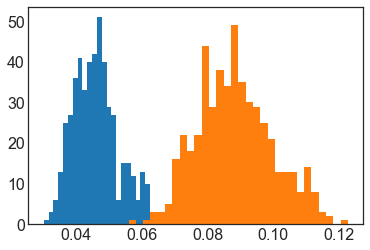

In [112]:
plt.hist(corr1k05['dA1'],bins=30)
plt.hist(corr1k05['da1'],bins=30)

(array([ 3.,  4.,  5.,  9.,  3.,  9., 10., 15., 22., 22., 30., 38., 35.,
        31., 43., 30., 33., 31., 31., 20., 19.,  8., 14., 12.,  5.,  5.,
         5.,  3.,  2.,  3.]),
 array([0.01450614, 0.01474141, 0.01497668, 0.01521195, 0.01544722,
        0.01568249, 0.01591776, 0.01615302, 0.01638829, 0.01662356,
        0.01685883, 0.0170941 , 0.01732937, 0.01756464, 0.0177999 ,
        0.01803517, 0.01827044, 0.01850571, 0.01874098, 0.01897625,
        0.01921152, 0.01944679, 0.01968205, 0.01991732, 0.02015259,
        0.02038786, 0.02062313, 0.0208584 , 0.02109367, 0.02132893,
        0.0215642 ]),
 <a list of 30 Patch objects>)

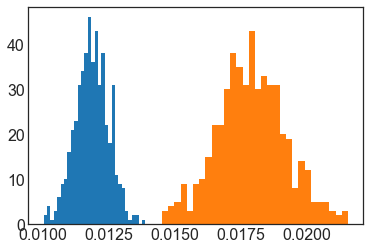

In [113]:
plt.hist(corr1k05['dA2'],bins=30)
plt.hist(corr1k05['da2'],bins=30)

In [125]:
print(corr1k05['A1'].std()/corr1k05['dA1'].mean())
print(corr1k05['A2'].std()/corr1k05['dA2'].mean())
print(corr1k05['D'].std()/corr1k05['dD'].mean())
print(corr1k05['dA1dA2'].mean()/corr1k05['da1da2'].mean())
print(corr1k05['dA1dD'].mean()/corr1k05['da1dd'].mean())
print(corr1k05['dA2dD'].mean()/corr1k05['dasdd'].mean())

1.77874321265467
1.5404351024757192
1.2958553992809057
40.64491663022437
10.457861352406862
2.307133132175551


(array([ 2.,  6.,  5.,  6., 11., 22., 15., 23., 30., 34., 26., 42., 42.,
        34., 50., 27., 27., 28., 20., 17.,  7., 11.,  5.,  6.,  2.,  0.,
         1.,  0.,  0.,  1.]),
 array([-8.39971723e-05, -7.71001886e-05, -7.02032050e-05, -6.33062213e-05,
        -5.64092376e-05, -4.95122540e-05, -4.26152703e-05, -3.57182866e-05,
        -2.88213029e-05, -2.19243193e-05, -1.50273356e-05, -8.13035193e-06,
        -1.23336826e-06,  5.66361541e-06,  1.25605991e-05,  1.94575827e-05,
         2.63545664e-05,  3.32515501e-05,  4.01485338e-05,  4.70455174e-05,
         5.39425011e-05,  6.08394848e-05,  6.77364684e-05,  7.46334521e-05,
         8.15304358e-05,  8.84274195e-05,  9.53244031e-05,  1.02221387e-04,
         1.09118370e-04,  1.16015354e-04,  1.22912338e-04]),
 <a list of 30 Patch objects>)

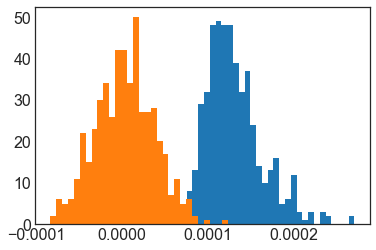

In [117]:
plt.hist(corr1k05['dA1dA2'],bins=30)
plt.hist(corr1k05['da1da2'],bins=30)

(array([ 1.,  3.,  2.,  1.,  8.,  9., 10., 18., 17., 24., 25., 43., 29.,
        33., 21., 31., 36., 37., 30., 31., 18., 10., 20.,  8., 14.,  7.,
         4.,  4.,  2.,  4.]),
 array([-1.14554256e-04, -1.00774023e-04, -8.69937895e-05, -7.32135565e-05,
        -5.94333234e-05, -4.56530904e-05, -3.18728573e-05, -1.80926243e-05,
        -4.31239126e-06,  9.46784179e-06,  2.32480748e-05,  3.70283079e-05,
         5.08085409e-05,  6.45887740e-05,  7.83690070e-05,  9.21492400e-05,
         1.05929473e-04,  1.19709706e-04,  1.33489939e-04,  1.47270172e-04,
         1.61050405e-04,  1.74830638e-04,  1.88610871e-04,  2.02391104e-04,
         2.16171337e-04,  2.29951570e-04,  2.43731804e-04,  2.57512037e-04,
         2.71292270e-04,  2.85072503e-04,  2.98852736e-04]),
 <a list of 30 Patch objects>)

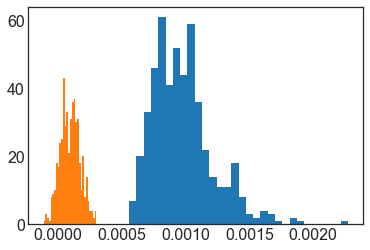

In [119]:
plt.hist(corr1k05['dA1dD'],bins=30)
plt.hist(corr1k05['da1dd'],bins=30)

(array([ 1.,  4.,  7.,  6.,  9., 14., 14., 25., 33., 42., 46., 43., 49.,
        52., 35., 33., 20., 13., 14., 14., 12.,  5.,  3.,  4.,  0.,  0.,
         0.,  1.,  0.,  1.]),
 array([2.24570230e-05, 2.61538454e-05, 2.98506679e-05, 3.35474903e-05,
        3.72443127e-05, 4.09411351e-05, 4.46379575e-05, 4.83347799e-05,
        5.20316023e-05, 5.57284247e-05, 5.94252471e-05, 6.31220695e-05,
        6.68188919e-05, 7.05157143e-05, 7.42125367e-05, 7.79093591e-05,
        8.16061815e-05, 8.53030039e-05, 8.89998263e-05, 9.26966487e-05,
        9.63934711e-05, 1.00090294e-04, 1.03787116e-04, 1.07483938e-04,
        1.11180761e-04, 1.14877583e-04, 1.18574406e-04, 1.22271228e-04,
        1.25968050e-04, 1.29664873e-04, 1.33361695e-04]),
 <a list of 30 Patch objects>)

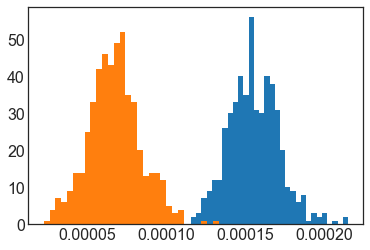

In [121]:
plt.hist(corr1k05['dA2dD'],bins=30)
plt.hist(corr1k05['dasdd'],bins=30)